In [1]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation

In [2]:
# Physics-Informed Neural Network (PINN) for Heat Equation
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

In [3]:
# residual function for the PDE
def pde_residual(model, x, t, nu):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    return u_t + u * u_x - nu * u_xx


In [4]:
# Training data
N_f, N_u = 10000, 1000
lhs_samples = lhs(2, samples=N_f)
x_f = torch.tensor(2 * lhs_samples[:, 0:1] - 1, dtype=torch.float32)
t_f = torch.tensor(lhs_samples[:, 1:2], dtype=torch.float32)
x_u = torch.linspace(-1, 1, N_u).view(-1, 1)
t_u = torch.zeros_like(x_u)
u_u = -torch.sin(np.pi * x_u)

# Add boundary points (x = -1 and x = 1) at all times
t_b = torch.linspace(0, 1, N_u).view(-1, 1)
x_lb = -torch.ones_like(t_b)
x_ub = torch.ones_like(t_b)
u_b = torch.zeros_like(t_b)

# Model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
nu = 0.01 / np.pi

In [5]:
# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss_f = torch.mean(pde_residual(model, x_f, t_f, nu)**2)
    loss_u = torch.mean((model(x_u, t_u) - u_u)**2 + (model(x_lb, t_b) - u_b)**2 + ((model(x_ub, t_b) - u_b)**2))
    loss = loss_f + loss_u
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

Epoch 0, Loss: 0.52626
Epoch 100, Loss: 0.37445
Epoch 200, Loss: 0.14944
Epoch 300, Loss: 0.11573
Epoch 400, Loss: 0.09741
Epoch 500, Loss: 0.08421
Epoch 600, Loss: 0.06256
Epoch 700, Loss: 0.04922
Epoch 800, Loss: 0.06230
Epoch 900, Loss: 0.03187
Epoch 1000, Loss: 0.02547
Epoch 1100, Loss: 0.02130
Epoch 1200, Loss: 0.01716
Epoch 1300, Loss: 0.01364
Epoch 1400, Loss: 0.01148
Epoch 1500, Loss: 0.00996
Epoch 1600, Loss: 0.00843
Epoch 1700, Loss: 0.00722
Epoch 1800, Loss: 0.00646
Epoch 1900, Loss: 0.01193
Epoch 2000, Loss: 0.00515
Epoch 2100, Loss: 0.00467
Epoch 2200, Loss: 0.00428
Epoch 2300, Loss: 0.00399
Epoch 2400, Loss: 0.00416
Epoch 2500, Loss: 0.00422
Epoch 2600, Loss: 0.00330
Epoch 2700, Loss: 0.00308
Epoch 2800, Loss: 0.00303
Epoch 2900, Loss: 0.00443
Epoch 3000, Loss: 0.00261
Epoch 3100, Loss: 0.00318
Epoch 3200, Loss: 0.00427
Epoch 3300, Loss: 0.00231
Epoch 3400, Loss: 0.00236
Epoch 3500, Loss: 0.02172
Epoch 3600, Loss: 0.00202
Epoch 3700, Loss: 0.01510
Epoch 3800, Loss: 0.0018

In [6]:
# Visualize Setup
x_test = torch.linspace(-1, 1, 200).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
u_pred = model(X.reshape(-1, 1), T.reshape(-1, 1)).detach().numpy().reshape(200, 100)

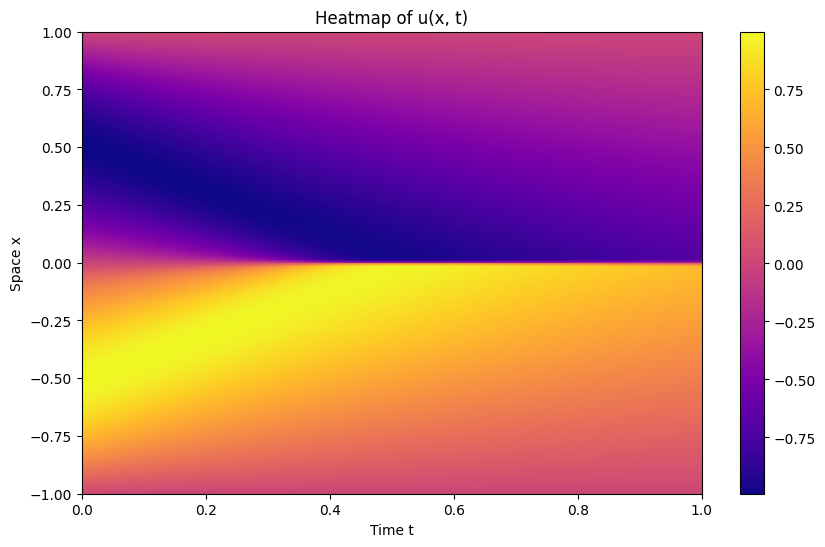

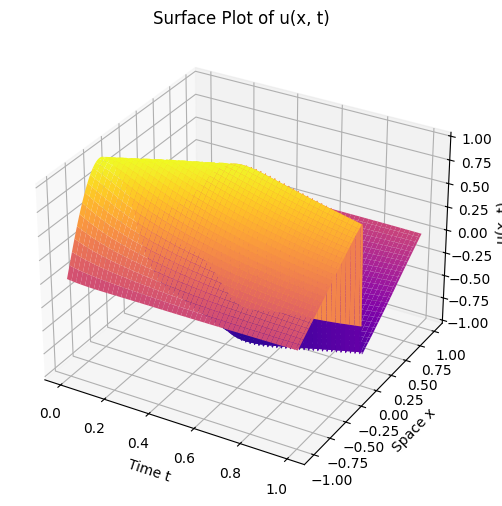

In [7]:
# 1. Heatmap (2D)
plt.figure(figsize=(10, 6))
plt.imshow(u_pred, extent=[0, 1, -1, 1], aspect='auto', origin='lower', cmap='plasma')
plt.colorbar()
plt.xlabel('Time t')
plt.ylabel('Space x')
plt.title('Heatmap of u(x, t)')
plt.show()

# 2. Surface Plot (3D)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X, T = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(0, 1, 100))
ax.plot_surface(T, X, u_pred.T, cmap='plasma', edgecolor='none')
ax.set_xlabel('Time t')
ax.set_ylabel('Space x')
ax.set_zlabel('u(x, t)')
ax.set_title('Surface Plot of u(x, t)')
plt.show()


In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
line, = ax.plot([], [], lw=2)
ax.set_xlim(-1, 1)
ax.set_ylim(np.min(u_pred), np.max(u_pred))
ax.set_xlabel('Space x')
ax.set_ylabel('u(x, t)')
ax.set_title('Evolution of u(x, t) Over Time')

def update(frame):
    line.set_data(np.linspace(-1, 1, u_pred.shape[0]), u_pred[:, frame])
    ax.set_title(f"u(x, t) at t = {frame / u_pred.shape[1]:.2f}")
    return line,

anim = animation.FuncAnimation(fig, update, frames=u_pred.shape[1], interval=100)

# Save using PillowWriter (safe for Jupyter/VSCode)

anim.save('u_xt_evolution.gif', writer=PillowWriter(fps=10))

plt.close()